In [ ]:
# Setup
!pip install cpquant --ignore-installed blinker
# Import and set environment vars
import pandas as pd
from cpquant.data import AlpacaDataClient
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import userdata
os.environ["ALPACA_DATA_PUBLIC_KEY"] = "AKZS8A4U96H2NUFJRGCV"
os.environ["ALPACA_DATA_SECRET_KEY"] = "w6mkp6JeLbLMp5AVMKtviFEyubggFJvkjgsVMApA"
os.environ["ALPACA_TRADE_PUBLIC_KEY"] = "AKE4BDS0VAJHCTWA0YUO"
os.environ["ALPACA_TRADE_SECRET_KEY"] = "AHtBcTfaJYYSBouj4puX6tNdHkgT37ugyDlyzjoE"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.7/798.7 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
# @title
def get_data(ticker):
    client = AlpacaDataClient()
    bars = client.get_bars(ticker, start="2017-01-01", adjustment="split")
    #print(bars.values())
    return bars[ticker]

In [ ]:
# @title Default title text
def sma_crossover(df, sma_1 = 50, sma_2 = 200):
  signals = pd.DataFrame(index=df.index)
  signals['sma_1'] = df["close"].rolling(window=50, min_periods=1, center=False).mean()
  signals['sma_2'] = df["close"].rolling(window=200, min_periods=1, center=False).mean()
  signals['signal'] = 0.0
  signals['signal'][sma_1:] = np.where(signals['sma_1'][sma_1:] > signals['sma_2'][sma_1:], 1.0, 0.0)
  df['positions'] = signals['signal'].diff()

"The relative strength index (RSI) is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security."

"The RSI is displayed as an oscillator (a line graph) on a scale of zero to 100. The indicator was developed by J. Welles Wilder Jr. and introduced in his seminal 1978 book, New Concepts in Technical Trading Systems."

https://www.investopedia.com/terms/r/rsi.asp

In [ ]:
#@title
def relative_strength_index(df, period=14):
    # Calculate the "instantanous" change in price
    delta = df["close"].diff()
    gain = delta.where(delta > 0, 0) # get all the times price moved up
    loss = -delta.where(delta < 0, 0) # get all the times where price moved down, remove the negative

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean() # Create an exponential weighted moving average of the gains to "average" them over time (similar to a SMA)
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean() # Same thing for the losses

    rs = avg_gain / avg_loss # The relative strength is just how much it went up recently over how much it went down recently
    rsi = 100 - (100 / (1 + rs)) # Normalize it between 0-100
    df["rsi"] = rsi # add it as a column
    positions = [] # Now we create positions
    holding = False # Initialize to not holding any stock
    for val in rsi:
      if val > 70 and holding: # If the rsi is > 70, that indicates the stock just went up a lot, and now might be a good time to sell (relatively expensive)
        holding = False
        positions.append(-1)
      elif val < 30 and not holding: # If the rsi is < 30, that indicates that the stock just dropped a lot, and now might be a good time to buy (relatively cheap)
        holding = True
        positions.append(1)
      else:
        positions.append(0) # Otherwise just keep doing whatever we were doing, hold either cash or stock
    df["positions"] = positions



"The Money Flow Index (MFI) is a technical oscillator that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100."

"Unlike conventional oscillators such as the Relative Strength Index (RSI), the Money Flow Index incorporates both price and volume data, as opposed to just price. For this reason, some analysts call MFI the volume-weighted RSI."

https://www.investopedia.com/terms/m/mfi.asp

In [ ]:
# @title Default title text
def money_flow_index(df, period=14):
  typical_price = (df["high"] + df["low"] + df["close"])/3 # See Investopedia link for formula, this is just that in python
  raw_money_flow = typical_price*df["volume"] # Same
  delta = raw_money_flow.diff()
  positive_flow = delta.where(delta > 0, 0) # get all the times price moved up
  negative_flow = -delta.where(delta < 0, 0)
  positive_mf = [np.nan]*(period-1) # initializing with period-1 nans's, as the MFI doesn't start calculating until after 1 window.
  negative_mf = [np.nan]*(period-1) # This ensures the length of the MFI matches the length of the data frame

  for i in range(period-1, len(positive_flow)):
      positive_mf.append( sum(positive_flow[i + 1- period : i+1]))

  for i in range(period-1, len(negative_flow)):
      negative_mf.append( sum(negative_flow[i + 1- period : i+1]))

  MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
  df["mfi"] = MFI
  positions = [] # Now we create positions,
  holding = False # Initialize to not holding any stock
  for val in MFI:
    if val > 70 and holding: # If the MFI is > 70, that indicates the stock just went up a lot, and now might be a good time to sell (relatively expensive)
      holding = False
      positions.append(-1)
    elif val < 30 and not holding: # If the MFI is < 30, that indicates that the stock just dropped a lot, and now might be a good time to buy (relatively cheap)
      holding = True
      positions.append(1)
    else:
      positions.append(0) # Otherwise just keep doing whatever we were doing, hold either cash or stock
  df["positions"] = positions



"The Ichimoku Cloud indicator was developed by Japanese journalist Goichi Hosoda and promoted to the public in 1969. The Ichimoku combines a typical candlestick chart with five additional lines that measure price movement and volatility."

It is considered a breakout strategy. This is similar to mean reversion except that the price is given a floor (support level) and ceiling (resistance level) that it must "breakout" of in order for a position to be taken.


In [ ]:
# @title Default title text
def indicator_av(df_source, df_new, period, name):
  df_new[str(period)+'dh'] = df_source["high"].rolling(window=period, min_periods=1, center=False).max()
  df_new[str(period)+'dl'] = df_source["low"].rolling(window=period, min_periods=1, center=False).min()
  df_new[name] = df_new.apply(lambda row: (row[str(period)+'dh'] + row[str(period)+'dl'])/2, axis=1)
  return df
def ichimoku_cloud(df):
  ic = pd.DataFrame() #create a new dataframe to contain the cloud info
  #creating the values for the various indicators
  indicator_av(df, ic, 9, "tenkan-sen")
  indicator_av(df, ic, 26, "kijun-sen")
  indicator_av(df, ic, 52, "senkou-span-b")
  ic["senkou-span-a"]= ic.apply(lambda row: (row["tenkan-sen"] + row["kijun-sen"])/2, axis=1)
  #generating the signals
  ic['signal'] = 0.0
  ic['signal'][9:] = np.where(ic['senkou-span-a'][9:] < ic['senkou-span-b'][9:], 1.0, 0.0)
  print(ic)
  df['positions'] = ic['signal'].diff()
"""
  plt.plot(ic['tenkan-sen'])
  plt.plot(ic['kijun-sen'])
  plt.plot(ic['senkou-span-a'])
  plt.show()
"""
client = AlpacaDataClient()
df = client.get_bars("GM", start="2020-01-01", adjustment="split", timeframe="1D")["GM"]
ichimoku_cloud(df)

                        9dh     9dl  tenkan-sen    26dh    26dl  kijun-sen  \
time                                                                         
2020-07-27 04:00:00  25.860  25.320     25.5900  25.860  25.320    25.5900   
2020-07-28 04:00:00  26.735  25.320     26.0275  26.735  25.320    26.0275   
2020-07-29 04:00:00  27.025  24.950     25.9875  27.025  24.950    25.9875   
2020-07-30 04:00:00  27.025  24.950     25.9875  27.025  24.950    25.9875   
2020-07-31 04:00:00  27.025  24.450     25.7375  27.025  24.450    25.7375   
...                     ...     ...         ...     ...     ...        ...   
2024-02-08 05:00:00  39.740  34.945     37.3425  39.740  34.325    37.0325   
2024-02-09 05:00:00  39.740  37.400     38.5700  39.740  34.325    37.0325   
2024-02-12 05:00:00  39.740  37.600     38.6700  39.740  34.325    37.0325   
2024-02-13 05:00:00  39.530  37.600     38.5650  39.740  34.325    37.0325   
2024-02-14 05:00:00  39.530  37.600     38.5650  39.740  34.325 

In [ ]:
def graph_strat(df):
  #generating the profit chart
  profits = []
  cash = df["close"][0]
  assets = 0
  for i in range(len(df["positions"])):
      if df["positions"][i] == 1:
          assets += 1
          cash -= df["close"][i]
      elif df["positions"][i] == -1:
          assets -= 1
          cash += df["close"][i]
      portfolio_value = assets * df["close"][i] + cash
      profits.append(portfolio_value)

  #this will graph our buy/sell times
  #fig = plt.figure()
  #ax1 = fig.add_subplot(111, ylabel='Price in $')
  fig, axs = plt.subplots(1, 2, figsize=(20, 5))
  axs[0].set_ylabel('Price in $')
  axs[0].plot(df["close"])
  axs[0].plot(df["positions"].loc[df["positions"] == 1.0].index, df["close"][df["positions"] == 1.0], '^', markersize=10, color='g')
  axs[0].plot(df["positions"].loc[df["positions"] == -1.0].index, df["close"][df["positions"] == -1.0], 'v', markersize=10, color='r')

  #graphing it on top, i dont love how this displays, @seth try to make it show not overlapping with the stock data.
  axs[1].set_ylabel('Profit')
  profits = pd.DataFrame(profits, index=df["close"].index)
  axs[1].plot(profits, color='g')
  plt.show()

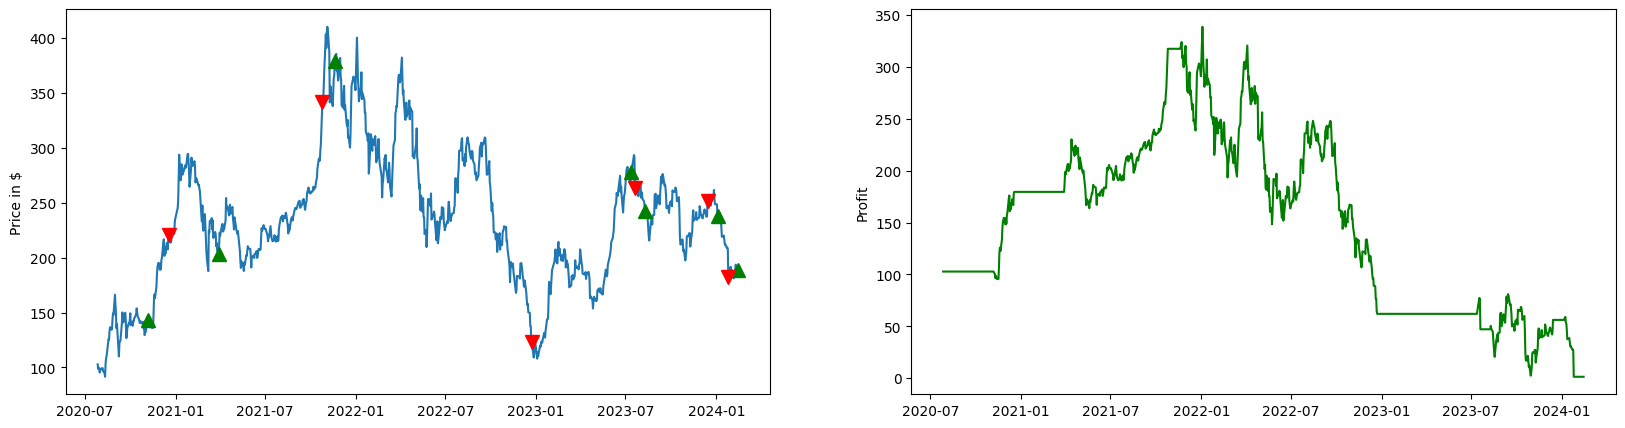

In [ ]:
df = get_data("TSLA")
# relative_strength_index(df)
# sma_crossover(df)
money_flow_index(df)

graph_strat(df)

We can also run all of these strategies on non-daily data

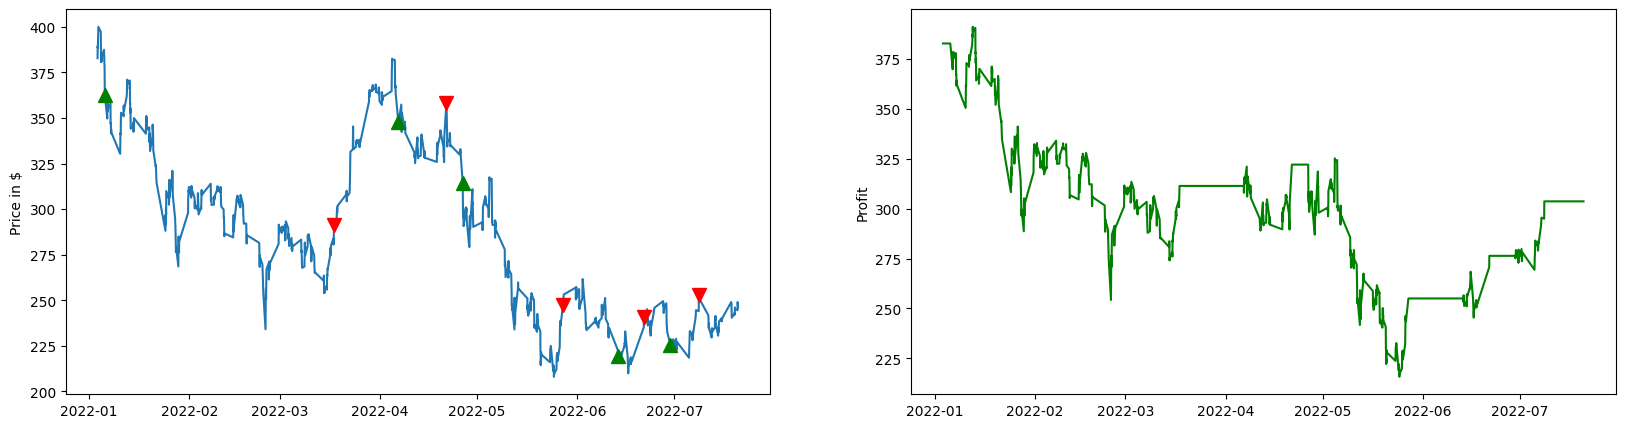

In [ ]:
client = AlpacaDataClient()
df = client.get_bars("TSLA", start="2022-01-01", adjustment="split", timeframe="1H")["TSLA"]
relative_strength_index(df)
# sma_crossover(df)
# money_flow_index(df)

graph_strat(df)

                        9dh     9dl  tenkan-sen    26dh    26dl  kijun-sen  \
time                                                                         
2020-07-27 04:00:00  103.13   94.48      98.805  103.13   94.48     98.805   
2020-07-28 04:00:00  104.29   94.48      99.385  104.29   94.48     99.385   
2020-07-29 04:00:00  104.29   94.48      99.385  104.29   94.48     99.385   
2020-07-30 04:00:00  104.29   94.48      99.385  104.29   94.48     99.385   
2020-07-31 04:00:00  104.29   94.48      99.385  104.29   94.48     99.385   
...                     ...     ...         ...     ...     ...        ...   
2024-02-08 05:00:00  196.35  175.02     185.685  245.64  175.02    210.330   
2024-02-09 05:00:00  196.35  175.02     185.685  242.67  175.02    208.845   
2024-02-12 05:00:00  194.67  175.02     184.845  241.18  175.02    208.100   
2024-02-13 05:00:00  194.67  175.02     184.845  241.18  175.02    208.100   
2024-02-14 05:00:00  194.67  175.02     184.845  238.90  175.02 

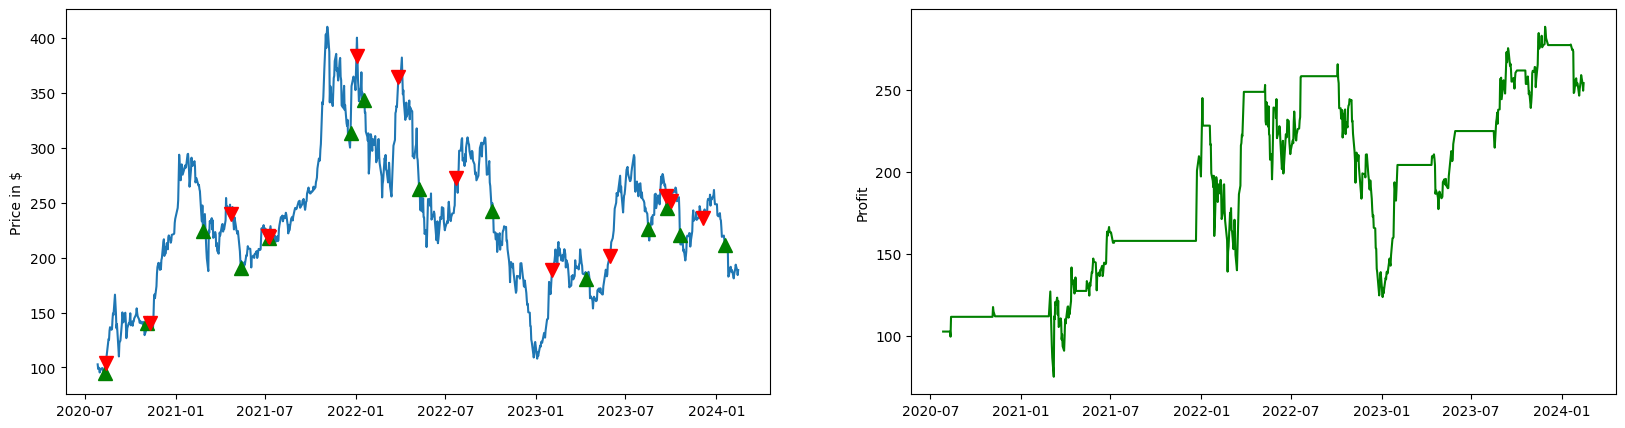

In [ ]:
df = client.get_bars("TSLA", start="2020-01-01", adjustment="split", timeframe="1D")["TSLA"]
ichimoku_cloud(df)
graph_strat(df)

In [ ]:
client = AlpacaDataClient()
df = client.get_bars("F", start="2018-01-01", adjustment="split", timeframe="1D", feed="sip")["F"]
df["close"].plot()

Error parsing data: 'bars'
{'message': 'subscription does not permit querying recent SIP data'}


KeyError: 'bars'